<a href="https://colab.research.google.com/github/frederikvanduuren/Mentor/blob/master/Session_6A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Basic Intuition
1.  If train_acc is low then increase complexity of your model (or add more data lol)
2.  If train_acc high and val_acc rather low (#overfitting) -> then apply regularizations (BN, DropOut, Kernel regularizers)
### other options could be:
3. mean-std normalization of images
4. Data Augmentation (ImageDataGenerator in Keras)



Deep neural nets with a large number of parameters are very powerful machine learning systems. However, overfitting is a serious problem in such networks.  Given below are few techniques which were proposed recently and has become a general norm these days in convolutional neural networks.

Dropout is a technique for addressing this problem. The key idea is to randomly drop units (along with their connections) from the neural network during training. The reduction in number of parameters in each step of training has effect of regularization. Dropout has shown improvements in the performance of neural networks on supervised learning tasks in vision, speech recognition, document classification and computational biology, obtaining state-of-the-art results on many benchmark data sets [1].

Kernel_regularizer  allows to apply penalties on layer parameters during optimization. These penalties are incorporated in the loss function that the network optimizes. This argument in convolutional layer  is nothing but L2 regularisation of the weights. This penalizes peaky weights and makes sure that all the inputs are considered. During gradient descent parameter update, the above L2 regularization ultimately means that every weight is decayed linearly, that’s why called weight decay.

BatchNormalization normalizes the activation of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. It addresses the problem of internal covariate shift. It also acts as a regularizer, in some cases eliminating the need for Dropout. Batch Normalization achieves the same accuracy with fewer training steps thus speeding up the training process [

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import optimizers

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [0]:
! pip install wandb
! wandb login 02d32f311f4a871d8e69b91f9ab2532052b9b622


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
import wandb
from wandb.keras import WandbCallback
wandb.init(project="session-6a")

W&B Run: https://app.wandb.ai/frederikvanduuren/session-6a/runs/25050839

In [0]:
import os 

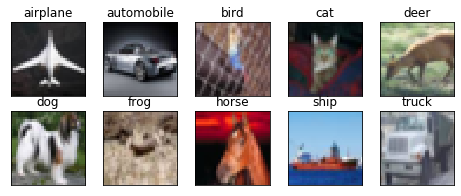

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

Images must be Z-score (mean-std) normalized because that’s how we have implemented while training also. Z-score normalization is important because it results in similarly-ranged feature values and that the gradients don’t go out of control (need one global learning rate multiplier).

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# mean-std normalization
mean = np.mean(train_features,axis=(0,1,2,3))
std = np.std(train_features,axis=(0,1,2,3))
train_features = (train_features-mean)/(std+1e-7)
test_features = (test_features-mean)/(std+1e-7)

# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
from keras import regularizers
# Define the model
weight_decay = 1e-4
model = Sequential()
model.add(Convolution2D(48, 3, 3, border_mode='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(48, 3, 3, ))
#model.add(Convolution2D(48, 1))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2)) # dropout 20%
model.add(Convolution2D(96, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(96, 3, 3, ))
#model.add(Convolution2D(96, 1))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3)) # dropout 30%
model.add(Convolution2D(192, 3, 3,border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(192, 3, 3, ))
#model.add(Convolution2D(192, 1))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40)) # dropout 40%
model.add(Convolution2D(10, 2))
model.add(Flatten())
#model.add(Dense(512))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
#model.add(Dense(256))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
#model.add(Dense(num_classes, activation='softmax'))
model.add(Activation('softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
#rmspop = optimizers.RMSprop(lr=0.001, rho=0.9)
#model.compile(optimizer=rmspop, loss='categorical_crossentropy', metrics=['accuracy'])
#adamax = optimizers.Adamax()
#model.compile(optimizer=adamax, loss='categorical_crossentropy', metrics=['accuracy'])
#nadam = optimizers.Nadam()
#model.compile(optimizer=nadam, loss='categorical_crossentropy', metrics=['accuracy'])

#wandb.init(name="BN > RELU > MXP > DO")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  """





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3))`


In [0]:
model.summary()

In keras, fit() is much similar to sklearn's fit method, where you pass array of features as x values and target as y values. You pass your whole dataset at once in fit method. Also, use it if you can load whole data into your memory (small dataset).

In fit_generator(), you don't pass the x and y directly, instead they come from a generator. As it is written in keras documentation, generator is used when you want to avoid duplicate data when using multiprocessing. This is for practical purpose, when you have large dataset.

A thing you should know about Keras if you plan to train a deep learning model on a large dataset:
https://towardsdatascience.com/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<wandb.ke..., steps_per_epoch=390, epochs=50)`
  app.launch_new_instance()




Epoch 1/50
  5/390 [..............................] - ETA: 3:53 - loss: 3.5750 - acc: 0.1562

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.117103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


390/390 [==============================] - 29s 75ms/step - loss: 1.6368 - acc: 0.4592 - val_loss: 1.2557 - val_acc: 0.5514
Epoch 2/50
390/390 [==============================] - 26s 67ms/step - loss: 1.0829 - acc: 0.6277 - val_loss: 0.8735 - val_acc: 0.7027
Epoch 3/50
390/390 [==============================] - 26s 67ms/step - loss: 0.8352 - acc: 0.7072 - val_loss: 0.7743 - val_acc: 0.7310
Epoch 4/50
390/390 [==============================] - 26s 67ms/step - loss: 0.7049 - acc: 0.7533 - val_loss: 0.7423 - val_acc: 0.7378
Epoch 5/50
390/390 [==============================] - 26s 67ms/step - loss: 0.6251 - acc: 0.7828 - val_loss: 0.6256 - val_acc: 0.7859
Epoch 6/50
390/390 [==============================] - 26s 67ms/step - loss: 0.5622 - acc: 0.8040 - val_loss: 0.6049 - val_acc: 0.7958
Epoch 7/50
390/390 [==============================] - 26s 67ms/step - loss: 0.5110 - acc: 0.8234 - val_loss: 0.6135 - val_acc: 0.7964
Epoch 8/50
390/390 [==============================] - 26s 67ms/step - los

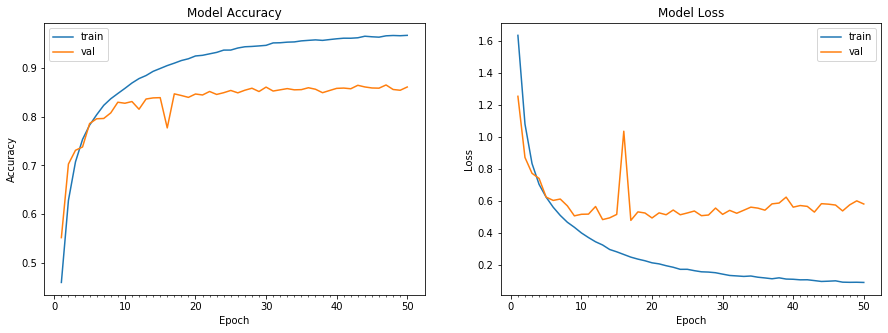

Accuracy on test data is: 86.11


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, horizontal_flip=False)

#datagen = ImageDataGenerator(zca_whitening=True)
#datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)

from keras.callbacks import EarlyStopping
#callbacks = [EarlyStopping(monitor='val_acc', patience=2)]

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks=[WandbCallback()])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))